C:\Users\BMEi\AppData\Local\Temp\ipykernel_26532\2736544671.py:38: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  paths_2d, _ = section.to_planar()
C:\Users\BMEi\AppData\Local\Temp\ipykernel_26532\2736544671.py:38: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  paths_2d, _ = section.to_planar()
C:\Users\BMEi\AppData\Local\Temp\ipykernel_26532\2736544671.py:38: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  paths_2d, _ = section.to_planar()
C:\Users\BMEi\AppData\Local\Temp\ipykernel_26532\2736544671.py:38: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  paths_2d, _ = section.to_planar()
C:\Users\BMEi\AppData\Local\Temp\ipykernel_26532\2736544671.py:38: DeprecationWarning: DEPRECATED: replace `path.to_planar`->`path.to_2D), removal 1/1/2026
  paths_2d, _ = section.to_planar()
C:\Users\BMEi\AppData\Local\Temp\ipykern

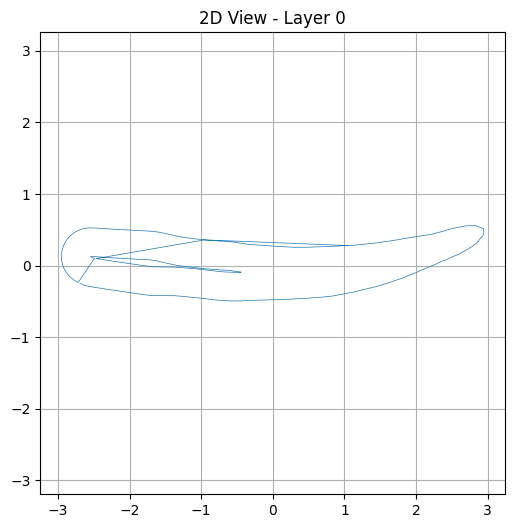

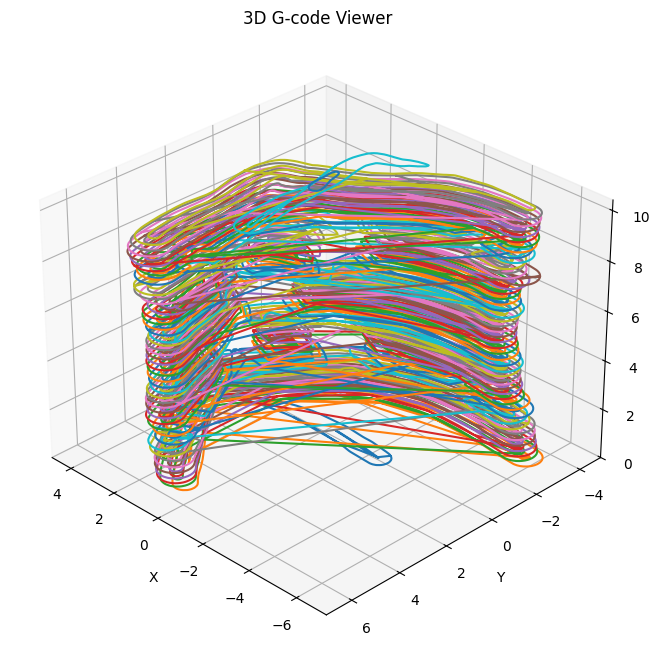

; G-code generated in memory
G21
G90
G28
G92 E0
M104 S200
M140 S60
M109 S200
M190 S60
; Layer 0
G1 Z0.20 F9000
G1 X-2.72 Y-0.23 F9000
G1 F3600
G1 X-2.69 Y-0.25 E0.00119
G1 X-2.68 Y-0.25 E0.00088
G1 X-2.66 Y-0.26 E0.00103
G1 X-2.64 Y-0.27 E0.00095
G1 X-2.63 Y-0.27 E0.00030
G1 X-2.61 Y-0.28 E0.00093
G1 X-2.61 Y-0.28 E0.00015
G1 X-2.60 Y-0.28 E0.00041
G1 X-2.57 Y-0.29 E0.00131
G1 X-2.56 Y-0.29 E0.00034
G1 X-2.54 Y-0.29 E0.00114
G1 X-2.53 Y-0.29 E0.00036
G1 X-2.51 Y-0.30 E0.00071
G1 X-2.50 Y-0.30 E0.00067
G1 X-2.48 Y-0.30 E0.00096
G1 X-2.46 Y-0.31 E0.00102
G1 X-2.45 Y-0.31 E0.00033


In [1]:
import trimesh
import numpy as np
from shapely.geometry import Polygon, LineString, MultiLineString, MultiPolygon
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re

# === โหลด STL ===
mesh = trimesh.load_mesh("repaired_print_demo90deg.stl")

# === ตั้งค่าการพิมพ์ ===
layer_height = 0.2
nozzle_diameter = 0.4
extrusion_multiplier = 0.045
travel_speed = 150
print_speed = 60
wall_count = 2
infill_spacing = 2.0  # mm

# === เตรียม G-code ===
gcode = []
gcode += [
    "; G-code generated in memory",
    "G21", "G90", "G28", "G92 E0",
    "M104 S200", "M140 S60", "M109 S200", "M190 S60"
]

z = layer_height
layer_num = 0
positions_by_layer = []

while z < mesh.bounds[1][2]:
    section = mesh.section(plane_origin=[0, 0, z], plane_normal=[0, 0, 1])
    if section is None:
        z += layer_height
        continue

    paths_2d, _ = section.to_planar()
    polygons = [p for p in paths_2d.polygons_full if p.exterior and len(p.exterior.coords) >= 3]

    if not polygons:
        z += layer_height
        continue

    gcode.append(f"; Layer {layer_num}")
    gcode.append(f"G1 Z{z:.2f} F{travel_speed * 60}")
    layer_positions = []

    for poly in polygons:
        if not poly.is_valid or poly.is_empty:
            continue

        shell = poly
        for wall in range(wall_count):
            # ✅ Handle both Polygon and MultiPolygon
            sub_polygons = [shell] if isinstance(shell, Polygon) else list(shell.geoms)
            for sub_poly in sub_polygons:
                if sub_poly.is_empty or not sub_poly.exterior:
                    continue
                coords = list(sub_poly.exterior.coords)
                start_x, start_y = coords[0]
                gcode.append(f"G1 X{start_x:.2f} Y{start_y:.2f} F{travel_speed * 60}")
                gcode.append(f"G1 F{print_speed * 60}")
                last_x, last_y = start_x, start_y
                for x, y in coords[1:]:
                    dist = np.linalg.norm([x - last_x, y - last_y])
                    e_value = extrusion_multiplier * dist
                    gcode.append(f"G1 X{x:.2f} Y{y:.2f} E{e_value:.5f}")
                    last_x, last_y = x, y
                    layer_positions.append([x, y, z])
            shell = shell.buffer(-nozzle_diameter)

        # === Infill ===
        minx, miny, maxx, maxy = poly.bounds
        x = minx
        while x <= maxx:
            line = LineString([(x, miny), (x, maxy)])
            clipped = line.intersection(poly)
            if isinstance(clipped, LineString):
                infill_lines = [clipped]
            elif isinstance(clipped, MultiLineString):
                infill_lines = list(clipped.geoms)
            else:
                infill_lines = []

            for line in infill_lines:
                coords = list(line.coords)
                if len(coords) < 2:
                    continue
                x0, y0 = coords[0]
                gcode.append(f"G1 X{x0:.2f} Y{y0:.2f} F{travel_speed * 60}")
                gcode.append(f"G1 F{print_speed * 60}")
                for x1, y1 in coords[1:]:
                    dist = np.linalg.norm([x1 - x0, y1 - y0])
                    e_value = extrusion_multiplier * dist
                    gcode.append(f"G1 X{x1:.2f} Y{y1:.2f} E{e_value:.5f}")
                    layer_positions.append([x1, y1, z])
                    x0, y0 = x1, y1
            x += infill_spacing

    positions_by_layer.append(layer_positions)
    z += layer_height
    layer_num += 1

gcode += ["M104 S0", "M140 S0", "G28 X0", "M84"]

# === 2D Viewer (เลเยอร์แรก) ===
plt.figure(figsize=(6, 6))
layer0 = np.array(positions_by_layer[0])
plt.plot(layer0[:, 0], layer0[:, 1], linewidth=0.5)
plt.title("2D View - Layer 0")
plt.axis("equal")
plt.grid(True)
plt.show()

# === 3D Viewer ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for layer in positions_by_layer:
    arr = np.array(layer)
    if len(arr) > 0:
        ax.plot(arr[:, 0], arr[:, 1], arr[:, 2])
ax.set_title("3D G-code Viewer")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=30, azim=135)
plt.show()

# === แสดงตัวอย่าง G-code 30 บรรทัดแรก ===
print("\n".join(gcode[:30]))

In [ ]:
pip install --upgrade -r requirements.txt